# **1.Treinamento**

In [75]:
#Primeiro passo -> normalizar
#Segundo passo -> calibrar o número de grupos do cluster (Otimização)
#Terceiro passo -> treinar e salvar o modelo de cluster
#Quarto passo -> descrever os grupos do modelo (Centróides)
#Quinto passo => definir a qual grupo uma nova instância pertence

In [76]:
##1. Normalização
from google.colab import drive 
drive.mount('/content/drive')

import pandas as pd
pd.__version__
dados = pd.read_csv('/content/drive/MyDrive/Sistemas Inteligentes Avançados/dados_normalizar.csv', sep = ';')

print(dados)
# Normalizar atributos numéricos
dados['novacol']=0 # Criando uma nova coluna no dataframe 

#dados['idade'].min()
#dados['idade'].max()

# Normalizar usando a equação Min/Max 
dados['n_idade'] = (dados['idade']-dados['idade'].min())/(dados['idade'].max()-dados['idade'].min())
dados[['idade', 'n_idade']]

# Normalizar usando a biblioteca
# Passo 1: instalar a lib para normalização
from sklearn import preprocessing #biblioteca com pré processador
# Criando objeto normalizador
normalizador = preprocessing.MinMaxScaler()

# Passo 2: segmentar a base, separando os atributos numéricos
dados_num = dados.drop(columns = ['sexo', 'n_idade', 'novacol'])
dados_num

# Passo 3: obter o modelo normalizador e salvar para uso posterior
# Modelo normalizador possui os pesos!
modelo_normalizador = normalizador.fit(dados_num) # O método fit() é responsável por obter o modelo que normalizará a base
dados_num_normalizado = normalizador.fit_transform(dados_num) # responsável por aplicar a normalização (por isso o termo 'transforma')
# Alternativa ->
#dados_num_normalizado = modelo_normalizador.fit_transform(dados_num) 

dummy_separator = '&'


# Passo 4: salvar o modelo normalizador em disco 
from pickle import dump, load #compactador
dump(modelo_normalizador, open('normalizador1.model', 'wb'))

dados_num_normalizado = normalizador.fit_transform(dados_num)

dados_num_normalizado

# Normalizar dados categóricos
# Passo 1: Segmentar os dados categóricos
dados_cat = dados[['sexo']] # Com dois colchetes ele converte para Data Frame
print(type(dados_cat))

# Passo 2: normalizar com get_dummies() do pandas
dados_cat_normalizado = pd.get_dummies(dados_cat,prefix_sep=dummy_separator)
dados_cat_normalizado

# Remontar o Data Frame

# Você pode criar dois objetos separados, um pra normalizar e outro para criar o DataFrame, mas consome bastante memória!
# Ou você pode usar o mesmo, mas isso é code smell

# Reconstruir o Data Frame com os dados numéricos normalizados 
dados_num = pd.DataFrame(dados_num_normalizado, columns = dados_num.columns)
dados_num

# Juntar com os dados categóricos normalizados
dados = dados_num.join(dados_cat_normalizado, how = 'left')
dados


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     idade  altura  Peso sexo
0       48       1   107    F
1       10       1   240    F
2       79       1    68    F
3       42       1   160    F
4       23       2   157    F
..     ...     ...   ...  ...
195     89       2    64    M
196     15       1    49    M
197     68       1   140    F
198     12       1   225    M
199     73       1    63    M

[200 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>


,idade,altura,Peso,sexo&F,sexo&M
0,0.474747,0.0,0.432653,1,0
1,0.090909,0.0,0.975510,1,0
2,0.787879,0.0,0.273469,1,0
3,0.414141,0.0,0.648980,1,0
4,0.222222,1.0,0.636735,1,0
...,...,...,...,...,...
195,0.888889,1.0,0.257143,0,1
196,0.141414,0.0,0.195918,0,1
197,0.676768,0.0,0.567347,1,0
198,0.111111,0.0,0.914286,0,1


In [77]:
##2.Calibração de cluster (achar a melhor arquitetura para ser utilizada)
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np


distorcoes = []
K = range(1, 101) #intervalo fechado à esquerda e aberto à direita
for k in K:
  #treinamento
  modelo = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(dados) #fit é o método que gera o modelo
  #print(modelo.cluster_centers_)
  #Kmeans é o metaestimador, o resultado é o estimador
  #Qual o conjunto ótimo de hiperparâmetros para obter o melhor modelo possível?
  distorcoes.append(
      sum(np.min(
          #Avalia as distâncias dos centroides, pega a mínima e guarda, depois tira a média e joga na matriz
          cdist(dados, modelo.cluster_centers_, 'euclidean'), axis=1))/dados.shape[0] #o shape trás o número de linhas 
  )


#Média da soma das menores distâncias de cada treinamento -> distorções


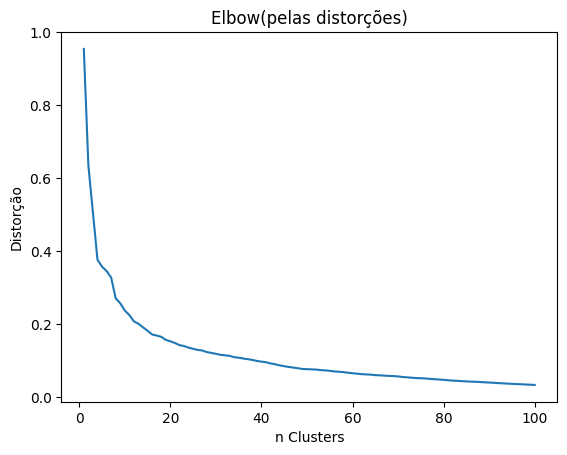

In [78]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(K, distorcoes)
ax.set(xlabel='n Clusters', ylabel='Distorção', title='Elbow(pelas distorções)')
fig.savefig('dados_distorcao_.png')
plt.show()

In [79]:
#Calcular número ideal de clusters
import math
x0 = K[0]
y0 = distorcoes[0]

x1 = K[len(K)-1]
y1 = distorcoes[len(distorcoes)-1]

distancias = []
for i in range(len(distorcoes)):
  x = K[i]
  y = distorcoes[i]
  numerador = abs((y1-y0)*x - (x1-x0)*y + x1*y0 - y1*x0)
  denominador = math.sqrt((y1-y0)**2 + (x1-x0)**2)
  distancias.append(numerador/denominador)

#maior distância
n_clusters_otimo = K[distancias.index(np.max(distancias))]
print('Número ideal de clusters : ', K[distancias.index(np.max(distancias))])

Número ideal de clusters :  12


In [90]:
#Treinar o modelo definitivo usando a melhor arquitetura encontrada no passo anterior
#Salvar em memória o modelo
from pickle import dump

modelo = KMeans(n_clusters=n_clusters_otimo, random_state=42, n_init='auto').fit(dados)

dump(modelo, open('cluster1.model', 'wb'))

 

In [81]:
dados

,idade,altura,Peso,sexo&F,sexo&M
0,0.474747,0.0,0.432653,1,0
1,0.090909,0.0,0.975510,1,0
2,0.787879,0.0,0.273469,1,0
3,0.414141,0.0,0.648980,1,0
4,0.222222,1.0,0.636735,1,0
...,...,...,...,...,...
195,0.888889,1.0,0.257143,0,1
196,0.141414,0.0,0.195918,0,1
197,0.676768,0.0,0.567347,1,0
198,0.111111,0.0,0.914286,0,1


In [82]:
#Desnormalizar dados categóricos

# 1. Criar um DataFrame que contém os centroides do cluster como linhas e as os dados como colunas (12 x 4)
cluster = pd.DataFrame(modelo.cluster_centers_, columns=dados.columns)
cluster

,idade,altura,Peso,sexo&F,sexo&M
0,0.734568,0.000000e+00,0.694785,1.0,0.0
1,0.762963,-1.110223e-16,0.449252,0.0,1.0
2,0.254856,1.000000e+00,0.230455,1.0,0.0
3,0.696970,1.000000e+00,0.718912,0.0,1.0
4,0.454545,1.110223e-16,0.265661,1.0,0.0
5,0.324827,0.000000e+00,0.186037,0.0,1.0
6,0.198232,1.000000e+00,0.604252,0.0,1.0
7,0.888215,1.000000e+00,0.357007,1.0,0.0
8,0.367424,1.000000e+00,0.731633,1.0,0.0
9,0.197358,-1.110223e-16,0.806279,0.0,1.0


In [83]:
# 2. Criar um dataframe que contém os dados categóricos do cluster, e verifica se ele está presente ou não em cada centroide
cluster_cat_data = cluster[dados_cat_normalizado.columns].round(0).abs().astype(int)==1

cluster_cat_data

,sexo&F,sexo&M
0,True,False
1,False,True
2,True,False
3,False,True
4,True,False
5,False,True
6,False,True
7,True,False
8,True,False
9,False,True


In [84]:
# Desnormalizar dados numéricos

# Só contem os dados numéricos, e retorna os dados a sua escala anterior
cluster_data_num = cluster.drop(columns=dados_cat_normalizado.columns)
dados_num_desnormalizado = normalizador.inverse_transform(cluster_data_num)

# Converte os dados desnormalizados para dataframe e usa o nomes originais das colunas
dados_num_desnormalizado = pd.DataFrame(dados_num_desnormalizado, columns=dados_num.columns)
print(dados_num_desnormalizado)


        idade  altura        Peso
0   73.722222     1.0  171.222222
1   76.533333     1.0  111.066667
2   26.230769     2.0   57.461538
3   70.000000     2.0  177.133333
4   46.000000     1.0   66.086957
5   33.157895     1.0   46.578947
6   20.625000     2.0  149.041667
7   88.933333     2.0   88.466667
8   37.375000     2.0  180.250000
9   20.538462     1.0  198.538462
10  27.333333     1.0  191.333333
11  80.357143     2.0   56.857143


In [85]:
# Cria um df vazio que vai armazenar as descrições categóricas de cada nucleo
cluster_description = pd.DataFrame(columns = dados_cat.columns)

# Pega o nome original das colunas
num_columns = dados_num.columns

cluster_desc = {}

In [86]:
# intera em cada linha do cluster_cat_data
for i in range(0,len(cluster_cat_data)):
  # seleciona cada linha e cria um df que a contém
  cluster = cluster_cat_data.filter(items=[i], axis=0)
  # intera em cada coluna de dados categóricos
  for c in cluster.columns:
    if c.find('&')>=0:
      # se a linha atual df do cluster é True, ou seja, se esse valor está presente nesse cluster
      if (cluster[c].values):
        print("coluna " + c)
        c = (c.split('&'))
        print(c[1] + " " + str(i))
        cluster_desc[c[0]]=c[1]
    else:
      cluster_desc[c] = str(cluster_desc[c].values[0])
      print(cluster_desc[c])
  cluster_description=cluster_description.append(cluster_desc, ignore_index=True)



coluna sexo&F
F 0
coluna sexo&M
M 1
coluna sexo&F
F 2
coluna sexo&M
M 3
coluna sexo&F
F 4
coluna sexo&M
M 5
coluna sexo&M
M 6
coluna sexo&F
F 7
coluna sexo&F
F 8
coluna sexo&M
M 9
coluna sexo&F
F 10
coluna sexo&M
M 11


<ipython-input-86-56ccd0e79491>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_description=cluster_description.append(cluster_desc, ignore_index=True)
<ipython-input-86-56ccd0e79491>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_description=cluster_description.append(cluster_desc, ignore_index=True)
<ipython-input-86-56ccd0e79491>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_description=cluster_description.append(cluster_desc, ignore_index=True)
<ipython-input-86-56ccd0e79491>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_description=cluster_description.append(cluster_desc, ignore_index=Tr

In [87]:
dados2 = dados_num_desnormalizado.join(cluster_description, how = 'left')
print(type(dados_num_desnormalizado))
dados2

<class 'pandas.core.frame.DataFrame'>


,idade,altura,Peso,sexo
0,73.722222,1.0,171.222222,F
1,76.533333,1.0,111.066667,M
2,26.230769,2.0,57.461538,F
3,70.000000,2.0,177.133333,M
4,46.000000,1.0,66.086957,F
5,33.157895,1.0,46.578947,M
6,20.625000,2.0,149.041667,M
7,88.933333,2.0,88.466667,F
8,37.375000,2.0,180.250000,F
9,20.538462,1.0,198.538462,M


In [88]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- #

In [89]:
import pickle 
modelo = pickle.load(open('/content/cluster1.model', 'rb'))
modelo

KMeans(n_clusters=12, n_init='auto', random_state=42)